## Agentic RAG for Nigerian Tax Reform Bills

### **Purpose:** fight misinformation with source-backed answers

### **Focus:** AI Engine (LangGraph + RAG)

In [1]:
# Imports
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from dotenv import load_dotenv
from IPython.display import Image, display, Markdown
from typing import Literal, List, Optional, TypedDict
import os
import re
from langchain_core.messages import BaseMessage
import logging

In [2]:
# Load API key
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

if not openai_api_key:
    raise ValueError("OPENAI_API_KEY not found! Please set it in your .env file.")

print("✅ API key loaded")

✅ API key loaded


In [3]:
# Initialize LLM
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.5,
    api_key=openai_api_key
)

print(f"✅ LLM initialized: {llm.model_name}")

✅ LLM initialized: gpt-4o-mini


In [4]:
# # file path
# file_path = ".\documents"


# def extract_act_metadata(filename: str):
#     name = filename.replace(".pdf", "").strip()

#     # Extract year
#     year_match = re.search(r"(20\d{2})", name)
#     year = int(year_match.group(1)) if year_match else None

#     # Clean title
#     clean_title = (
#         name.replace("_", " ")
#             .replace(",", "")
#             .replace("EDITED", "")
#             .replace("FRIDAY", "")
#             .strip()
#     )

#     return {
#         "document_title": clean_title.title(),
#         "act_name": clean_title.title(),
#         "year": year,
#         "document_type": "Act",
#         "jurisdiction": "Nigeria",
#         "source_file": filename
#     }


# async def load_all_pdfs(pdf_dir: str):
#     pages = []

#     for filename in os.listdir(pdf_dir):
#         if filename.lower().endswith(".pdf"):
#             file_path = os.path.join(pdf_dir, filename)
#             loader = PyPDFLoader(file_path)

#             async for page in loader.alazy_load():
#                 base_metadata = extract_act_metadata(filename)

#                 page.metadata.update(base_metadata)
#                 page.metadata["page_number"] = page.metadata.get("page")
#                 # page.metadata["source"] = filename
#                 pages.append(page)

#     return pages

# documents = await load_all_pdfs(file_path)
# print(f"Loaded {len(documents)} pages from PDFs")

In [5]:
# file path
file_path = ".\documents"


ALLOWED_METADATA_KEYS = {
    "document_title",
    "act_name",
    "year",
    "document_type",
    "jurisdiction",
    "source_file",
    "page_number",
}

def extract_act_metadata(filename: str):
    name = filename.replace(".pdf", "").strip()

    # Extract year if present
    year_match = re.search(r"(20\d{2})", name)
    year = int(year_match.group(1)) if year_match else None

    # Clean up filename into a readable title
    clean_title = (
        name.replace("_", " ")
            .replace(",", "")
            .replace("EDITED", "")
            .replace("FRIDAY", "")
            .strip()
    )

    return {
        "document_title": clean_title.title(),
        "act_name": clean_title.title(),
        "year": year,
        "document_type": "Act",
        "jurisdiction": "Nigeria",
        "source_file": filename,
    }

async def load_all_pdfs(pdf_dir: str):
    pages = []

    for filename in os.listdir(pdf_dir):
        if not filename.lower().endswith(".pdf"):
            continue

        file_path = os.path.join(pdf_dir, filename)
        loader = PyPDFLoader(file_path)

        async for page in loader.alazy_load():
            # Build clean metadata
            metadata = extract_act_metadata(filename)

            # Use human-readable page number
            page_number = page.metadata.get("page_label")
            metadata["page_number"] = int(page_number) if page_number and page_number.isdigit() else None

            # Replace metadata completely (drop noisy PDF fields)
            page.metadata = {
                k: v for k, v in metadata.items()
                if k in ALLOWED_METADATA_KEYS
            }

            pages.append(page)

    return pages

documents = await load_all_pdfs(file_path)
print(f"Loaded {len(documents)} pages from PDFs")

<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\user234\AppData\Local\Temp\ipykernel_18192\3670399849.py:2: SyntaxWarning: invalid escape sequence '\d'
  file_path = ".\documents"


Loaded 374 pages from PDFs


**Why Legal Documents Need Special Chunking**

Legal and policy documents are structured differently from regular text, with sections often spanning multiple paragraphs that must be read together to preserve meaning. Definitions introduced early in an Act frequently affect how later provisions should be interpreted, so losing context can lead to incorrect answers. Overly small chunks risk breaking up legally connected ideas, while overly large chunks reduce retrieval precision and introduce irrelevant information. A balanced chunking strategy is therefore essential to ensure accurate, context-aware retrieval for legal documents.

In [6]:
# Create text splitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,      
    chunk_overlap=150     
)

# Split documents
doc_splits = text_splitter.split_documents(documents)

print(f"✅ Created {len(doc_splits)} chunks")
print(f"\nSample chunk:")
print(f"{doc_splits[0].page_content[:500]}...")
print(doc_splits[0].metadata)

✅ Created 995 chunks

Sample chunk:
2025  No. 6          A  347Joint Revenue Boar d of Nigeria
(Establishment) Act, 2025
Federal Republic of Nigeria
Official Gazette
No. 117 Lagos—26th  June, 2025 Vol. 112
Government Notice  No. 25
The following is published as supplement to this Gazette :
Act No. Short Title Page
6.  Joint Revenue Board of Nigeria (Establishment) Act, 2025 .. A349-382
Extraordinary
Printed and Published by The Federal Government Printer, Lagos, Nigeria
FGP 29/72025/500
Annual Subscription from 1st January , 2025 ...
{'document_title': 'Joint Revenue Board Of Nigeria (Establishment) Act 2025 B', 'act_name': 'Joint Revenue Board Of Nigeria (Establishment) Act 2025 B', 'year': 2025, 'document_type': 'Act', 'jurisdiction': 'Nigeria', 'source_file': 'Joint Revenue Board of Nigeria (Establishment) Act, 2025 B.pdf', 'page_number': 1}


**Vector Store and Embeddings**

Embeddings are used to convert legal text into numerical representations that allow the system to retrieve relevant policy provisions based on semantic similarity rather than exact keyword matches. Chroma was chosen as the vector store because it is lightweight, easy to integrate, and well-suited for local experimentation and academic projects. Each embedded text chunk retains its original metadata, including the Act name and page number, which enables accurate source attribution. This ensures that all generated answers can be traced back to specific provisions in the official tax documents.

In [7]:
# Initialize embeddings (using OpenAI)
embeddings = OpenAIEmbeddings(
    model="text-embedding-3-small",
    api_key=openai_api_key
)

print("Embeddings model initialized")

Embeddings model initialized


In [8]:
chroma_path = "./chroma_db"
collection_name = "tax_act"

# Check if Chroma DB already exists
db_exists = os.path.exists(chroma_path) and len(os.listdir(chroma_path)) > 0

if db_exists:
    print("Existing Chroma DB found. Loading...")
    
    vectorstore = Chroma(
        collection_name=collection_name,
        persist_directory=chroma_path,
        embedding_function=embeddings
    )

else:
    print("No existing Chroma DB found. Creating new one...")
    
    vectorstore = Chroma(
        collection_name=collection_name,
        persist_directory=chroma_path,
        embedding_function=embeddings
    )
    
    vectorstore.add_documents(documents=doc_splits)


    print(f"Vector store created with {len(doc_splits)} chunks")
    print(f"   Persisted to: {chroma_path}")

No existing Chroma DB found. Creating new one...
Vector store created with 995 chunks
   Persisted to: ./chroma_db


In [9]:
query = "How does VAT affect state revenue allocation?"

results = vectorstore.similarity_search(query, k=3)

print(f"Query: {query}")
print("\nRetrieved Chunks:\n")

for i, doc in enumerate(results, 1):
    print(f"Result {i}")
    print(doc.metadata)
    print(doc.page_content[:300])
    print("-" * 40)

Query: How does VAT affect state revenue allocation?

Retrieved Chunks:

Result 1
{'act_name': 'Nigeria Tax Administration Act 2025', 'page_number': 50, 'year': 2025, 'document_title': 'Nigeria Tax Administration Act 2025', 'document_type': 'Act', 'source_file': 'NIGERIA TAX ADMINISTRATION ACT, 2025.pdf', 'jurisdiction': 'Nigeria'}
A  306         2025 No. 5 Nigeria Tax Administration Act, 2025
and
(c) 35% to the Local Governments.
(2) The amount of the V AT revenue standing to the credit of states and
local governments shall be distributed among them on the following basis –
(a) Equally - 50% ;
(b) Population - 20% ; and
(c) C
----------------------------------------
Result 2
{'act_name': 'Nigeria Tax Act 2025', 'document_title': 'Nigeria Tax Act 2025', 'source_file': 'NIGERIA TAX ACT 2025.pdf', 'year': 2025, 'page_number': 69, 'document_type': 'Act', 'jurisdiction': 'Nigeria'}
(a) added to the aggregate amount to be computed under subsection (2)
of this section for the succeeding acco

In [10]:
@tool
def retrieve_documents(query: str, k: int = 5) -> list:
    """
    Retrieve relevant legal document chunks from the Nigerian tax Acts.

    This tool should be used ONLY when policy evidence is required
    to answer a user's question.

    Args:
        query (str): A refined, legal-style search query
        k (int): Number of document chunks to retrieve

    Returns:
        list: A list of retrieved document chunks with metadata
    """

    retriever = vectorstore.as_retriever(
        search_type="mmr",
        search_kwargs={
            "k": k,
            "fetch_k": 10
        }
    )

    docs = retriever.invoke(query)

    if not docs:
        return []

    results = []

    for doc in docs:
        results.append({
            "content": doc.page_content,
            "document_title": doc.metadata.get("document_title"),
            "act_name": doc.metadata.get("act_name"),
            "page_number": doc.metadata.get("page_number"),
            "year": doc.metadata.get("year"),
            "jurisdiction": doc.metadata.get("jurisdiction"),
            "source_file": doc.metadata.get("source_file")
        })

    return results


print("Retriever tool successfully created.")


Retriever tool successfully created.


In [11]:
test_query = "How does VAT affect state revenue allocation in Nigeria?"

results = retrieve_documents.invoke(
    {"query": test_query, "k": 5}
)

print(f"Retrieved {len(results)} chunks\n")

for i, r in enumerate(results, 1):
    print(f"Result {i}")
    print("Act:", r["act_name"])
    print("Title:", r["document_title"])
    print("Page:", r["page_number"])
    print("Year:", r["year"])
    print("Content Preview:", r["content"][:300])
    print("-" * 60)

Retrieved 5 chunks

Result 1
Act: Nigeria Tax Administration Act 2025
Title: Nigeria Tax Administration Act 2025
Page: 50
Year: 2025
Content Preview: A  306         2025 No. 5 Nigeria Tax Administration Act, 2025
and
(c) 35% to the Local Governments.
(2) The amount of the V AT revenue standing to the credit of states and
local governments shall be distributed among them on the following basis –
(a) Equally - 50% ;
(b) Population - 20% ; and
(c) C
------------------------------------------------------------
Result 2
Act: Nigeria Tax Act 2025
Title: Nigeria Tax Act 2025
Page: 89
Year: 2025
Content Preview: Nigeria Tax Act, 2025 2025  No. 7        A  473
141.—(1) Where multiple instruments chargeable with advalorem duties
are executed for effecting the same transaction, only one of the instruments,
as may be determined by the relevant tax authority, shall be charged with the
ad valorem duty.
(2) Any ot
------------------------------------------------------------
Result 3
Act: Nigeria Tax 

In [12]:
test_query = "How will VAT revenue be shared among states?"

results = retrieve_documents.invoke(
    {"query": test_query, "k": 5}
)

print(f"Retrieved {len(results)} chunks\n")
print(f"query: {test_query}")

for i, r in enumerate(results, 1):
    print(f"Result {i}")
    print("Act:", r["act_name"])
    print("Title:", r["document_title"])
    print("Page:", r["page_number"])
    print("Year:", r["year"])
    print("Content Preview:", r["content"][:300])
    print("-" * 60)

Retrieved 5 chunks

query: How will VAT revenue be shared among states?
Result 1
Act: Nigeria Tax Administration Act 2025
Title: Nigeria Tax Administration Act 2025
Page: 50
Year: 2025
Content Preview: A  306         2025 No. 5 Nigeria Tax Administration Act, 2025
and
(c) 35% to the Local Governments.
(2) The amount of the V AT revenue standing to the credit of states and
local governments shall be distributed among them on the following basis –
(a) Equally - 50% ;
(b) Population - 20% ; and
(c) C
------------------------------------------------------------
Result 2
Act: Nigeria Tax Administration Act 2025
Title: Nigeria Tax Administration Act 2025
Page: 54
Year: 2025
Content Preview: to it by the State Board.
93.—(1) There shall be established for each local government area of a
State, a Committee to be known as the Local Government Revenue Committee
("Revenue Committee").
(2) The Revenue Committee shall comprise —
(a) the Local Government Supervisor for Finance, as Chairman ;
(
-----

In [13]:
system_prompt = SystemMessage(content="""
You are an AI assistant specialized in Nigerian tax law and public finance policy.
Your knowledge source is a collection of official Nigerian tax legislation,
including the Nigeria Tax Act 2025, Nigeria Tax Administration Act,
Nigeria Revenue Service Act, Joint Revenue Board of Nigeria (Establishment) Act,
and related government documents.

DOMAIN RESTRICTION:
Only answer questions related to:
- Nigerian tax laws and tax reforms
- VAT, income tax, and revenue administration
- Tax obligations of individuals and businesses
- Revenue allocation and derivation among federal, state, and local governments
- Institutional roles of Nigerian tax authorities

If a question is outside this domain, politely state that it is outside your scope.

RETRIEVAL DECISION RULES:

DO NOT retrieve for:
- Greetings or small talk
- Questions about your capabilities
- Simple clarifications that do not require legal citations

DO retrieve for:
- Questions about tax rates, obligations, exemptions, or penalties
- Questions involving revenue distribution or fiscal policy
- Any question where citing official Acts improves accuracy or trust

CITATION FORMAT RULES:

When using retrieved documents:
- Use numbered inline citations like [1], [2]
- End your response with a "Sources" section
- Each source must include the Act name and page number
- Do not invent citations
- Do not cite documents that were not retrieved

If the documents do not contain the answer, state this clearly.
Never fabricate legal provisions or policy interpretations.
""")



In [14]:
# Bind tool to LLM
tools = [retrieve_documents]
llm_with_tools = llm.bind_tools(tools)

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def assistant(state: MessagesState) -> dict:
    """
    Assistant node - decides whether to retrieve or answer directly.
    """
    # messages = [system_prompt] + state["messages"]
    messages = state["messages"]

    # Inject system prompt ONCE
    if not messages or messages[0].type != "system":
        messages = [system_prompt] + messages
        logger.info("System prompt injected")

    logger.info(f"User input: {messages[-1].content[:100]}")

    response = llm_with_tools.invoke(messages)

    if response.tool_calls:
        logger.info(f"Tool invoked: {response.tool_calls[0]['name']}")
    else:
        logger.info("No tool call – answering directly")

    return {"messages": [response]}


def should_continue(state: MessagesState) -> Literal["tools", "__end__"]:
    """
    Decide whether to call tools or finish.
    """
    last_message = state["messages"][-1]

    if last_message.tool_calls:
        return "tools"
    return "__end__"

In [15]:
# Build graph
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    should_continue,
    {"tools": "tools", "__end__": END}
)
builder.add_edge("tools", "assistant")

# Add memory
memory = MemorySaver()
agent = builder.compile(checkpointer=memory)

**“Why did you use MemorySaver?”**

“MemorySaver was chosen intentionally for the first version because it provides fast, in-memory conversational state suitable for prototyping and demonstrations. For production deployment, this would be replaced with a persistent checkpointer backed by Redis or a database.”

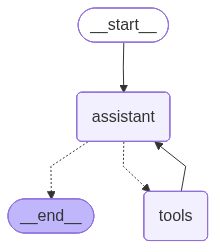

In [16]:
# Visualize the agentic RAG graph
try:
    display(Image(agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("Graph: START → assistant → [if tool_call] → tools → assistant → END")

In [17]:
def query_agent(user_input: str, thread_id: str = "default_session"):
    """
    Test harness for the Agentic RAG system.
    Shows whether retrieval was used and prints the final answer.
    """
    print(f"\n{'='*70}")
    print(f"👤 User: {user_input}")
    print(f"{'='*70}\n")

    result = agent.invoke(
        {"messages": [HumanMessage(content=user_input)]},
        config={"configurable": {"thread_id": thread_id}}
    )

    used_retrieval = False
    final_answer = None

    for message in result["messages"]:
        if isinstance(message, AIMessage):
            if message.tool_calls:
                used_retrieval = True
                print("🔍 Agent decided to retrieve documents...")
            if message.content and not message.tool_calls:
                final_answer = message.content

    if final_answer:
        print(f"🤖 Agent: {final_answer}")
    else:
        print("⚠️ No final answer generated.")

    print(f"\n📊 Decision: {'USED RETRIEVAL' if used_retrieval else 'ANSWERED DIRECTLY'}")
    print(f"{'='*70}\n")


In [19]:
query_agent("How will VAT revenue be shared among states?")

INFO:__main__:System prompt injected
INFO:__main__:User input: How will VAT revenue be shared among states?



👤 User: How will VAT revenue be shared among states?



INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:__main__:Tool invoked: retrieve_documents
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:__main__:System prompt injected
INFO:__main__:User input: [{"content": "A  306         2025 No. 5 Nigeria Tax Administration Act, 2025\nand\n(c) 35% to the Lo
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:__main__:No tool call – answering directly


🔍 Agent decided to retrieve documents...
🤖 Agent: The distribution of VAT revenue among states and local governments in Nigeria is outlined in the Nigeria Tax Administration Act, 2025. According to the provisions:

1. **Distribution Basis**:
   - 50% of the VAT revenue is shared equally among the states and local governments.
   - 20% is allocated based on population.
   - 30% is distributed based on consumption, which is determined by the place of consumption, irrespective of where the tax return is filed.

2. **Administrative Requirement**:
   - The relevant tax authority must furnish the Accountant-General of the Federation or the Accountant-General of the State with schedules containing a summary of taxes collected and tax refund claims within seven days after the end of each month.

This structured distribution aims to ensure a fair allocation of VAT revenue to support the fiscal needs of both state and local governments.

Sources:
- Nigeria Tax Administration Act, 2025, page 50.


In [21]:
query_agent("what if my annual income is 700k")

INFO:__main__:System prompt injected
INFO:__main__:User input: what if my annual income is 700k



👤 User: what if my annual income is 700k



INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:__main__:No tool call – answering directly


🔍 Agent decided to retrieve documents...
🔍 Agent decided to retrieve documents...
🤖 Agent: If your annual income is ₦700,000, you will not be required to pay any personal income tax in Nigeria. This is because your income is below the tax threshold of ₦800,000, which is taxed at a rate of 0%. Therefore, you will have no tax liability for that income.

In summary, with an annual income of ₦700,000, you are exempt from personal income tax.

Sources:
- Nigeria Tax Act, 2025, page 156.

📊 Decision: USED RETRIEVAL



In [48]:
query_agent("How will VAT revenue be shared among states?")

INFO:__main__:System prompt injected
INFO:__main__:User input: How will VAT revenue be shared among states?



👤 User: How will VAT revenue be shared among states?



INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:__main__:Tool invoked: retrieve_documents
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:__main__:System prompt injected
INFO:__main__:User input: [{"content": "and shall, immediately remit such deductions to the relevant tax authority.\n81. (1) N
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:__main__:No tool call – answering directly


🔍 Agent decided to retrieve documents...
🤖 Agent: The sharing of VAT revenue among states in Nigeria is governed by specific provisions in the tax legislation. According to the Nigeria Tax Administration Act, the net VAT revenue is distributed as follows:

1. **Distribution of Total Revenue**:
   - 10% to the Federal Government
   - 55% to the State Governments and the Federal Capital Territory (FCT)
   - 35% to the Local Governments

2. **Distribution among States and Local Governments**:
   The amount of VAT revenue allocated to states and local governments is further distributed based on the following criteria:
   - Equally among states and local governments: 50%
   - Based on population: 20%
   - Based on consumption: 30%

   For the purpose of this distribution, "consumption" is determined by the place of consumption, irrespective of where the VAT return is filed [1].

Sources:
1. Nigeria Tax Administration Act, page 49.

📊 Decision: USED RETRIEVAL



In [53]:
query_agent("Has a small buisness owner how much did i need to pay for tax")

INFO:__main__:System prompt injected
INFO:__main__:User input: Has a small buisness owner how much did i need to pay for tax



👤 User: Has a small buisness owner how much did i need to pay for tax



INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:__main__:Tool invoked: retrieve_documents
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:__main__:System prompt injected
INFO:__main__:User input: [{"content": "compliance under this Act or any other tax law ;\n\"relevant tax authority\" means Nig
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:__main__:No tool call – answering directly


🔍 Agent decided to retrieve documents...
🔍 Agent decided to retrieve documents...
🤖 Agent: As a small business owner in Nigeria, your tax obligations depend on your annual gross turnover and the nature of your business. According to the Nigeria Tax Administration Act, a "small business" is defined as one that earns a gross turnover of ₦50,000,000 or less per annum and has total fixed assets less than ₦250,000,000. However, businesses providing professional services are not classified as small businesses.

For small businesses, the primary tax obligations typically include:

1. **Company Income Tax (CIT)**: If your business is registered as a company, you are liable to pay Company Income Tax at a rate of 30% on your profits.

2. **Value Added Tax (VAT)**: If your business provides taxable goods or services, you must charge VAT at a rate of 7.5% on your sales and remit this to the tax authorities.

3. **Personal Income Tax (PIT)**: If you operate as a sole proprietorship, you will pay Pe

In [54]:
query_agent("How much did i need to earn to pay tax")

INFO:__main__:System prompt injected
INFO:__main__:User input: How much did i need to earn to pay tax



👤 User: How much did i need to earn to pay tax



INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:__main__:Tool invoked: retrieve_documents
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:__main__:System prompt injected
INFO:__main__:User input: [{"content": "Nigeria Tax Act, 20252025 No. 7A  478\nincome by way of personal emoluments, that inco
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:__main__:No tool call – answering directly


🔍 Agent decided to retrieve documents...
🔍 Agent decided to retrieve documents...
🔍 Agent decided to retrieve documents...
🤖 Agent: In Nigeria, individuals and businesses become liable to pay tax based on their level of income. For personal income tax, the relevant threshold is typically set around the national minimum wage. Specifically, individuals earning gross income equal to or less than the national minimum wage (which is currently ₦30,000 per month or ₦360,000 annually) are generally exempt from personal income tax obligations.

For businesses, particularly small businesses, the threshold for tax obligations is defined by the gross turnover. A business with a gross turnover of ₦50,000,000 or less per annum is classified as a small business, which may have different tax rates and obligations compared to larger businesses [1][2].

If you earn above these thresholds, you would be liable for tax, and the applicable rates would depend on whether you are taxed as an individual or as a

In [58]:
query_agent("If i ean above the minimum wage, how much do i need to ean to pay tax")

INFO:__main__:System prompt injected
INFO:__main__:User input: If i ean above the minimum wage, how much do i need to ean to pay tax



👤 User: If i ean above the minimum wage, how much do i need to ean to pay tax



INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:__main__:Tool invoked: retrieve_documents
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:__main__:System prompt injected
INFO:__main__:User input: [{"content": "Nigeria Tax Act, 20252025 No. 7A  478\nincome by way of personal emoluments, that inco
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:__main__:No tool call – answering directly


🔍 Agent decided to retrieve documents...
🔍 Agent decided to retrieve documents...
🔍 Agent decided to retrieve documents...
🔍 Agent decided to retrieve documents...
🤖 Agent: In Nigeria, if you earn above the national minimum wage, you become liable to pay personal income tax. The national minimum wage is currently set at ₦30,000 per month, which totals ₦360,000 annually. Therefore, if your gross annual income exceeds ₦360,000, you will be required to pay personal income tax.

The income tax rates are progressive, meaning that the tax rate increases as your income increases. Below is a simplified breakdown of the personal income tax rates applicable to individuals:

- **₦0 - ₦300,000**: 0%
- **₦300,001 - ₦600,000**: 7%
- **₦600,001 - ₦1,100,000**: 11%
- **₦1,100,001 - ₦1,600,000**: 15%
- **₦1,600,001 - ₦2,100,000**: 19%
- **₦2,100,001 and above**: 21%

If your income is above ₦360,000 annually, you will start incurring tax obligations based on these rates [1][2].

Sources:
1. Nigeria Tax

In [55]:
query_agent("How much did i need to earn to pay tax", "ade")

INFO:__main__:System prompt injected
INFO:__main__:User input: How much did i need to earn to pay tax



👤 User: How much did i need to earn to pay tax



INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:__main__:Tool invoked: retrieve_documents
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:__main__:System prompt injected
INFO:__main__:User input: [{"content": "Nigeria Tax Act, 20252025 No. 7A  478\nincome by way of personal emoluments, that inco
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:__main__:No tool call – answering directly


🔍 Agent decided to retrieve documents...
🤖 Agent: In Nigeria, individuals are subject to income tax if their earnings exceed the national minimum wage. As of the latest provisions in the Nigeria Tax Act 2025, individuals earning gross income equal to or less than the national minimum wage are not liable to pay income tax. This means that if your gross income is above the national minimum wage, you will be required to pay tax on the amount exceeding this threshold.

For specific figures regarding the national minimum wage, you may need to refer to the latest government announcements or regulations, as they can change periodically.

Sources:
1. Nigeria Tax Act 2025, page 94
2. Nigeria Tax Act 2025, page 41
3. Nigeria Tax Administration Act, page 78

📊 Decision: USED RETRIEVAL



In [57]:
query_agent("i am think people that earn up to 800000 are exempted", "ade")

INFO:__main__:System prompt injected
INFO:__main__:User input: i am think people that earn up to 800000 are exempted



👤 User: i am think people that earn up to 800000 are exempted



INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:__main__:Tool invoked: retrieve_documents
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:__main__:System prompt injected
INFO:__main__:User input: [{"content": "A  264         2025 No. 5 Nigeria Tax Administration Act, 2025", "document_title": "Ni
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:__main__:No tool call – answering directly


🔍 Agent decided to retrieve documents...
🔍 Agent decided to retrieve documents...
🔍 Agent decided to retrieve documents...
🤖 Agent: According to the current provisions in Nigerian tax law, there is no specific exemption threshold set at ₦800,000 for individual income tax. Instead, individuals earning gross income equal to or less than the national minimum wage (₦360,000 annually) are exempt from paying income tax. 

For income exceeding this threshold, tax rates apply progressively based on the income brackets, with higher rates for higher income levels. 

If you have further specifics about exemptions or tax reliefs that may apply to certain categories of earners, please let me know!

Sources:
1. Nigeria Tax Administration Act, page 8
2. Nigeria Tax Act 2025, page 41

📊 Decision: USED RETRIEVAL



In [49]:
def interactive_chat(thread_id: str):
    print("🤖 Interactive Chat (Notebook Mode)")
    print("Type 'exit' to quit\n")

    while True:
        user_input = input("👤 You: ").strip()

        if user_input.lower() in ["exit", "quit"]:
            display(Markdown("👋 **Goodbye!**"))
            break

        if not user_input:
            continue

        display(Markdown(f"**👤 You:** {user_input}"))

        thinking_display = display(
            Markdown("🤖 *Agent is thinking…*"),
            display_id=True
        )

        result = agent.invoke(
            {"messages": [HumanMessage(content=user_input)]},
            config={"configurable": {"thread_id": thread_id}}
        )

        used_retrieval = False
        final_answer = None

        for msg in result["messages"]:
            if isinstance(msg, AIMessage):
                if msg.tool_calls:
                    used_retrieval = True
                if msg.content and not msg.tool_calls:
                    final_answer = msg.content

        decision = "USED RETRIEVAL" if used_retrieval else "ANSWERED DIRECTLY"

        thinking_display.update(
            Markdown(
                f"**🤖 Agent:** {final_answer}\n\n"
                f"📊 **Decision:** `{decision}`"
            )
        )

In [52]:
interactive_chat("secssion-1")

🤖 Interactive Chat (Notebook Mode)
Type 'exit' to quit



**👤 You:** hello

**🤖 Agent:** I'm here to assist you with questions related to Nigerian tax laws and public finance policy. Please let me know how I can help you!

📊 **Decision:** `ANSWERED DIRECTLY`

INFO:__main__:System prompt injected
INFO:__main__:User input: hello
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:__main__:No tool call – answering directly


**👤 You:** How will VAT revenue be shared among states?

**🤖 Agent:** The sharing of VAT revenue among states in Nigeria is defined in the Nigeria Tax Administration Act. According to the provisions:

1. **Distribution of Net Revenue**:
   - 10% is allocated to the Federal Government.
   - 55% is allocated to the State Governments and the Federal Capital Territory.
   - 35% is allocated to Local Governments.

2. **Distribution Among States and Local Governments**:
   The amount of VAT revenue credited to states and local governments is distributed based on the following criteria:
   - 50% is shared equally among the states.
   - 20% is distributed based on population.
   - 30% is distributed based on consumption, which is determined by the place of consumption, regardless of where the return is filed [1].

These allocations ensure that both state and local governments receive a fair share of the VAT revenue collected.

Sources:
1. Nigeria Tax Administration Act, page 49

📊 **Decision:** `USED RETRIEVAL`

INFO:__main__:System prompt injected
INFO:__main__:User input: How will VAT revenue be shared among states?
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:__main__:Tool invoked: retrieve_documents
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:__main__:System prompt injected
INFO:__main__:User input: [{"content": "and shall, immediately remit such deductions to the relevant tax authority.\n81. (1) N
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:__main__:No tool call – answering directly


**👤 You:** When does the new tax law take effect?

**🤖 Agent:** The new tax laws, specifically the Nigeria Tax Act 2025 and the Nigeria Tax Administration Act 2025, are set to take effect from **1st January 2025**. This is indicated in the official gazette where the acts were published [1][2].

Sources:
1. Nigeria Tax Administration Act, page 8
2. Nigeria Tax Act 2025, page 1

📊 **Decision:** `USED RETRIEVAL`

INFO:__main__:System prompt injected
INFO:__main__:User input: When does the new tax law take effect?
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:__main__:Tool invoked: retrieve_documents
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:__main__:System prompt injected
INFO:__main__:User input: [{"content": "A  264         2025 No. 5 Nigeria Tax Administration Act, 2025", "document_title": "Ni
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:__main__:No tool call – answering directly


**👤 You:** Explain VAT derivation under the new system

**🤖 Agent:** Under the new VAT system established by the Nigeria Tax Act 2025, the derivation of VAT revenue is primarily focused on ensuring that VAT is levied on taxable supplies and that the collection and remittance processes are clearly defined. Here are the key points regarding VAT derivation:

1. **Taxable Supplies**: VAT is imposed on all taxable supplies made by registered persons in Nigeria. This includes both goods and services provided within the country, as well as imports [1].

2. **Importation**: For imported taxable supplies, the VAT value is determined based on the price of the taxable supply plus any applicable taxes, duties, and other charges incurred during importation, excluding VAT itself [2].

3. **Non-Residents**: Non-resident entities making taxable supplies to Nigeria must register for VAT and include VAT on their invoices. If they are making supplies from outside Nigeria, the recipient in Nigeria is responsible for withholding the VAT due and remitting it to the tax authority [2].

4. **Revenue Allocation**: After collection, VAT revenue is distributed among the federal, state, and local governments according to the established sharing formula, which includes provisions for equal distribution, population-based allocation, and consumption-based allocation [1].

5. **Compliance and Enforcement**: The relevant tax authority has the power to disregard transactions that are deemed artificial or fictitious, ensuring compliance with VAT regulations and preventing tax evasion [2].

These provisions aim to create a clear and efficient framework for VAT derivation and administration in Nigeria.

Sources:
1. Nigeria Tax Act 2025, page 88
2. Nigeria Tax Act 2025, page 113

📊 **Decision:** `USED RETRIEVAL`

INFO:__main__:System prompt injected
INFO:__main__:User input: Explain VAT derivation under the new system
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:__main__:Tool invoked: retrieve_documents
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:__main__:System prompt injected
INFO:__main__:User input: [{"content": "A  264         2025 No. 5 Nigeria Tax Administration Act, 2025", "document_title": "Ni
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:__main__:No tool call – answering directly


👋 **Goodbye!**

**Feature implementation**

In [23]:
class AgentState(TypedDict):
    messages: List[BaseMessage]
    intent: Optional[str]
    refined_query: Optional[str]
    retrieved_docs: Optional[list]

In [24]:
print(AgentState.__annotations__)

{'messages': typing.List[langchain_core.messages.base.BaseMessage], 'intent': typing.Optional[str], 'refined_query': typing.Optional[str], 'retrieved_docs': typing.Optional[list]}


In [25]:
def intent_analysis(state: AgentState) -> AgentState:
    messages = state["messages"]

    prompt = [
        system_prompt,
        *messages,
        SystemMessage(content="""
Classify the user's intent.
Respond with ONLY one word:
- retrieve (if document evidence is required)
- no_retrieve (if it is a greeting or general question)
""")
    ]

    response = llm.invoke(prompt)

    intent = response.content.strip().lower()

    return {
        **state,
        "intent": intent
    }

In [26]:
def route_on_intent(state: AgentState):
    if state["intent"] == "retrieve":
        return "refine_query"
    return "answer"

In [27]:
def refine_query(state: AgentState) -> AgentState:
    messages = state["messages"]

    prompt = [
        system_prompt,
        *messages,
        SystemMessage(content="""
Rewrite the user's question as a precise legal search query
suitable for retrieving provisions from Nigerian tax legislation.
Do not answer the question.
""")
    ]

    response = llm.invoke(prompt)

    return {
        **state,
        "refined_query": response.content.strip()
    }

In [28]:
def retrieve_node(state: AgentState) -> AgentState:
    results = retrieve_documents.invoke({
        "query": state["refined_query"],
        "k": 5
    })

    return {
        **state,
        "retrieved_docs": results
    }


In [29]:
def answer_synthesis(state: AgentState) -> AgentState:
    messages = state["messages"]
    docs = state.get("retrieved_docs", [])

    evidence_block = "\n\n".join(
        f"- {d['act_name']} (Page {d['page_number']}): {d['content']}"
        for d in docs
    )

    prompt = [
        system_prompt,
        *messages,
        SystemMessage(content=f"""
Use the following official legal provisions to answer the question.
Cite the Act name and page number in your answer.

LEGAL SOURCES:
{evidence_block}
""")
    ]

    response = llm.invoke(prompt)

    return {
        **state,
        "messages": messages + [response]
    }


In [30]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(AgentState)

builder.add_node("intent", intent_analysis)
builder.add_node("refine_query", refine_query)
builder.add_node("retrieve", retrieve_node)
builder.add_node("answer", answer_synthesis)

builder.add_edge(START, "intent")

builder.add_conditional_edges(
    "intent",
    route_on_intent,
    {
        "refine_query": "refine_query",
        "answer": "answer"
    }
)

builder.add_edge("refine_query", "retrieve")
builder.add_edge("retrieve", "answer")
builder.add_edge("answer", END)

memory = MemorySaver()
agents = builder.compile(checkpointer=memory)


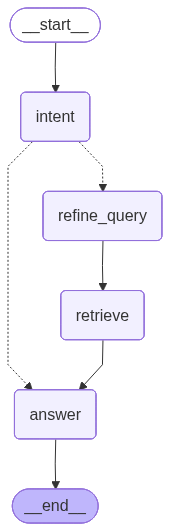

In [31]:
# Visualize the agentic RAG graph
try:
    display(Image(agents.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("Graph: START → assistant → [if tool_call] → tools → assistant → END")

In [37]:
initial_state = {
    "messages": [
        HumanMessage(content="How will VAT revenue be shared among states?")
    ],
    "intent": None,
    "refined_query": None,
    "retrieved_docs": None
}

result = agent.invoke(
    initial_state,
    config={
        "configurable": {
            "thread_id": "tax-demo-1"
        }
    }
)

final_answer = None

for message in result["messages"]:
    if isinstance(message, AIMessage):
        if message.tool_calls:
            print(f"🔍 Agent: [Calling retrieval tool...]")
        if message.content and not message.tool_calls:
            final_answer = message.content

# Always print final answer
if final_answer:
    print(f"🤖 Agent: {final_answer}")
else:
    print(f"⚠️ No response generated after retrieval!")

🔍 Agent: [Calling retrieval tool...]
🤖 Agent: The sharing of VAT revenue among states is defined in the Nigeria Tax Administration Act. The allocation is structured as follows:

1. **Total Distribution**:
   - 10% to the Federal Government
   - 55% to the State Governments and the Federal Capital Territory
   - 35% to the Local Governments

2. **Distribution Among States and Local Governments**:
   - The revenue allocated to State Governments and Local Governments is distributed as follows:
     - **Equally**: 50%
     - **Population**: 20%
     - **Consumption**: 30%

   The term "consumption" is determined by the place where the consumption occurs, regardless of where the VAT return is filed (Nigeria Tax Administration Act, page 49).

This formula ensures a fair distribution that considers both the population of each state and their respective consumption levels.


First agent

In [ ]:
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import ToolNode
from langchain_core.messages import SystemMessage, AIMessage
from langgraph.checkpoint.memory import MemorySaver
from typing import Literal
import logging

# Setup logging for debugging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Improved system prompt - more concise and clearer
system_prompt = SystemMessage(content="""
You are an AI assistant specialized in Nigerian tax law and public finance policy.
Your knowledge source is a collection of official Nigerian tax legislation,
including the Nigeria Tax Act 2025, Nigeria Tax Administration Act, Nigeria Revenue Service Act, JOINT REVENUE BOARD OF NIGERIA (ESTABLISHMENT) ACT,
and related government documents.

DOMAIN RESTRICTION:
Only answer questions related to:
- Nigerian tax laws and tax reforms
- VAT, income tax, and revenue administration
- Tax obligations of individuals and businesses
- Revenue allocation and derivation among federal, state, and local governments
- Institutional roles of Nigerian tax authorities

If a question is outside this domain, politely respond that it is outside your scope.

RETRIEVAL DECISION RULES:

DO NOT retrieve for:
- Greetings or small talk ("Hello", "Thank you")
- Questions about your capabilities
- Simple clarifications that do not require legal citations

DO retrieve for:
- Questions about tax rates, obligations, exemptions, or penalties
- Questions involving revenue distribution or government fiscal policy
- Any question where citing official Acts improves accuracy or trust

When documents are retrieved:
- Use them as the primary source of truth
- Cite the relevant Act and page number where possible
- If the documents do not contain the answer, state this clearly

Never fabricate legal provisions, tax rules, or policy interpretations.
""")

# Bind tool to LLM
tools = [retrieve_documents]
llm_with_tools = llm.bind_tools(tools)

def assistant(state: MessagesState) -> dict:
    """
    Assistant node with logging and improved system prompt handling.
    """
    messages = state["messages"]
    
    # Inject system prompt only once at the start
    if not messages or messages[0].type != "system":
        messages = [system_prompt] + messages
        logger.info("System prompt injected")
    
    # Log the decision point
    logger.info(f"Assistant processing message: {messages[-1].content[:100]}...")
    
    response = llm_with_tools.invoke(messages)
    
    # Log tool calling decision
    if response.tool_calls:
        logger.info(f"Tool called: {response.tool_calls[0]['name']}")
    else:
        logger.info("No tool call - answering directly")
    
    return {"messages": [response]}

def should_continue(state: MessagesState) -> Literal["tools", "__end__"]:
    """
    Routing decision with logging.
    """
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "tools"
    return "__end__"

def post_retrieval_check(state: MessagesState) -> dict:
    """
    Optional: Add a node to validate retrieval results before final answer.
    This helps catch cases where retrieval returns no useful results.
    """
    messages = state["messages"]
    last_tool_message = None
    
    # Find the last tool message
    for msg in reversed(messages):
        if msg.type == "tool":
            last_tool_message = msg
            break
    
    if last_tool_message and not last_tool_message.content:
        logger.warning("Retrieval returned no results")
        # You could add fallback logic here
    
    return {"messages": []}  # Pass through

# Build graph
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    should_continue,
    {"tools": "tools", "__end__": END}
)
builder.add_edge("tools", "assistant")

# Add memory
memory = MemorySaver()
agent = builder.compile(checkpointer=memory)

# Usage example with thread configuration
"""
config = {"configurable": {"thread_id": "user_123"}}
response = agent.invoke(
    {"messages": [("user", "What is the VAT rate in Nigeria?")]},
    config=config
)
print(response["messages"][-1].content)
"""

second agent

In [ ]:
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage, AIMessage
from langgraph.checkpoint.memory import MemorySaver
from typing import TypedDict, List, Optional
import logging

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class AgentState(TypedDict):
    messages: List[BaseMessage]
    intent: Optional[str]
    refined_query: Optional[str]
    retrieved_docs: Optional[list]
    metadata: Optional[dict]  # For tracking performance metrics

# Streamlined system prompt (define once, reuse efficiently)
SYSTEM_PROMPT = """
You are an AI assistant specialized in Nigerian tax law and public finance policy.
Your knowledge covers: Nigeria Tax Act 2025, Tax Administration Act, Revenue Service Act, 
Joint Revenue Board Act, and related legislation.

DOMAIN RESTRICTION:
Only answer questions about Nigerian tax laws, VAT, income tax, revenue administration, 
tax obligations, revenue allocation, and tax authority roles.
For out-of-scope questions, politely decline.
"""

def intent_analysis(state: AgentState) -> AgentState:
    """
    Classify user intent with structured output and logging.
    """
    messages = state["messages"]
    user_query = messages[-1].content
    
    # More structured intent classification prompt
    prompt = [
        SystemMessage(content=SYSTEM_PROMPT),
        HumanMessage(content=user_query),
        SystemMessage(content="""
Classify this query's intent. Respond with ONLY one word:
- retrieve: If the question requires citing specific tax laws, rates, provisions, or official documents
- no_retrieve: If it's a greeting, thank you, capability question, or simple clarification

Examples:
"What is the VAT rate?" → retrieve
"Hello" → no_retrieve
"Thank you" → no_retrieve
"What can you help with?" → no_retrieve
"What are the penalties for late tax filing?" → retrieve
""")
    ]
    
    response = llm.invoke(prompt)
    intent = response.content.strip().lower()
    
    logger.info(f"Intent classified as: {intent} for query: {user_query[:100]}")
    
    return {
        **state,
        "intent": intent,
        "metadata": {"intent_confidence": "high"}  # You could add confidence scoring
    }

def route_on_intent(state: AgentState):
    """Route based on intent classification."""
    if state["intent"] == "retrieve":
        return "refine_query"
    return "answer_direct"

def refine_query(state: AgentState) -> AgentState:
    """
    Optimize query for retrieval with better prompting.
    """
    messages = state["messages"]
    user_query = messages[-1].content
    
    prompt = [
        SystemMessage(content=SYSTEM_PROMPT),
        HumanMessage(content=user_query),
        SystemMessage(content="""
Transform this question into an optimized search query for retrieving Nigerian tax legislation.

Guidelines:
- Extract key legal concepts and tax terms
- Include relevant Act names if mentioned
- Make it specific and concise (5-15 words)
- Focus on searchable keywords

Example transformations:
"How much tax do I pay on my salary?" → "income tax rates salary PAYE Nigeria"
"What happens if I don't file taxes on time?" → "tax filing deadline penalties late submission"

Return ONLY the optimized search query, nothing else.
""")
    ]
    
    response = llm.invoke(prompt)
    refined = response.content.strip()
    
    logger.info(f"Query refined: '{user_query[:100]}' → '{refined}'")
    
    return {
        **state,
        "refined_query": refined
    }

def retrieve_node(state: AgentState) -> AgentState:
    """
    Retrieve documents with error handling and logging.
    """
    query = state["refined_query"]
    
    try:
        results = retrieve_documents.invoke({
            "query": query,
            "k": 5
        })
        
        logger.info(f"Retrieved {len(results)} documents for query: {query}")
        
        # Log if retrieval returned empty results
        if not results:
            logger.warning(f"No documents retrieved for query: {query}")
        
        return {
            **state,
            "retrieved_docs": results
        }
    except Exception as e:
        logger.error(f"Retrieval error: {str(e)}")
        return {
            **state,
            "retrieved_docs": [],
            "metadata": {**state.get("metadata", {}), "retrieval_error": str(e)}
        }

def answer_direct(state: AgentState) -> AgentState:
    """
    Answer without retrieval for greetings and simple queries.
    """
    messages = state["messages"]
    
    prompt = [
        SystemMessage(content=SYSTEM_PROMPT),
        *messages,
        SystemMessage(content="Respond appropriately to this message without citing documents.")
    ]
    
    response = llm.invoke(prompt)
    logger.info("Direct answer provided (no retrieval)")
    
    return {
        **state,
        "messages": messages + [response]
    }

def answer_synthesis(state: AgentState) -> AgentState:
    """
    Synthesize answer from retrieved documents with improved context.
    """
    messages = state["messages"]
    docs = state.get("retrieved_docs", [])
    
    # Handle case where no documents were retrieved
    if not docs:
        fallback_prompt = [
            SystemMessage(content=SYSTEM_PROMPT),
            *messages,
            SystemMessage(content="""
No relevant documents were found in the knowledge base for this query.
Politely inform the user that you don't have specific information on this topic
in the current document collection, but offer to help with related questions.
""")
        ]
        response = llm.invoke(fallback_prompt)
        logger.warning("Answering without documents - none retrieved")
    else:
        # Build evidence block from retrieved documents
        evidence_block = "\n\n".join(
            f"[Source {i+1}] {d['act_name']} (Page {d['page_number']}):\n{d['content']}"
            for i, d in enumerate(docs)
        )
        
        prompt = [
            SystemMessage(content=SYSTEM_PROMPT),
            *messages,
            SystemMessage(content=f"""
Answer the question using ONLY the official legal provisions below.
Requirements:
- Cite sources as [Source N] in your answer
- Include Act name and page number
- If the documents don't fully answer the question, say so
- Be precise and avoid speculation

LEGAL SOURCES:
{evidence_block}
""")
        ]
        
        response = llm.invoke(prompt)
        logger.info(f"Answer synthesized from {len(docs)} documents")
    
    return {
        **state,
        "messages": messages + [response]
    }

# Build graph
builder = StateGraph(AgentState)

# Add nodes
builder.add_node("intent", intent_analysis)
builder.add_node("refine_query", refine_query)
builder.add_node("retrieve", retrieve_node)
builder.add_node("answer_direct", answer_direct)
builder.add_node("answer", answer_synthesis)

# Define edges
builder.add_edge(START, "intent")
builder.add_conditional_edges(
    "intent",
    route_on_intent,
    {
        "refine_query": "refine_query",
        "answer_direct": "answer_direct"
    }
)
builder.add_edge("refine_query", "retrieve")
builder.add_edge("retrieve", "answer")
builder.add_edge("answer_direct", END)
builder.add_edge("answer", END)

# Compile with memory
memory = MemorySaver()
agent = builder.compile(checkpointer=memory)

# Usage example
"""
config = {"configurable": {"thread_id": "user_123"}}
response = agent.invoke(
    {"messages": [HumanMessage(content="What is the VAT rate in Nigeria?")]},
    config=config
)
print(response["messages"][-1].content)
"""

Evaluating the two Agents

In [ ]:
import time
import json
from typing import List, Dict, Any
from dataclasses import dataclass, asdict
import pandas as pd

@dataclass
class EvaluationMetrics:
    """Metrics for comparing agent performance."""
    agent_name: str
    query: str
    response: str
    latency_ms: float
    retrieved_docs_count: int
    answer_quality: int  # 1-5 scale
    citation_accuracy: int  # 1-5 scale
    relevance: int  # 1-5 scale
    notes: str = ""

class AgentEvaluator:
    """Framework for comparing two RAG agents."""
    
    def __init__(self, agent1, agent2, agent1_name="Agent 1", agent2_name="Agent 2"):
        self.agent1 = agent1
        self.agent2 = agent2
        self.agent1_name = agent1_name
        self.agent2_name = agent2_name
        self.results: List[EvaluationMetrics] = []
    
    def run_query(self, agent, query: str, thread_id: str) -> Dict[str, Any]:
        """Run a single query and measure performance."""
        config = {"configurable": {"thread_id": thread_id}}
        
        start_time = time.time()
        try:
            response = agent.invoke(
                {"messages": [("user", query)]},
                config=config
            )
            latency = (time.time() - start_time) * 1000  # Convert to ms
            
            # Extract response text
            answer = response["messages"][-1].content
            
            # Try to count retrieved documents (implementation depends on agent structure)
            doc_count = self._count_retrieved_docs(response)
            
            return {
                "success": True,
                "answer": answer,
                "latency_ms": latency,
                "doc_count": doc_count
            }
        except Exception as e:
            latency = (time.time() - start_time) * 1000
            return {
                "success": False,
                "answer": f"Error: {str(e)}",
                "latency_ms": latency,
                "doc_count": 0
            }
    
    def _count_retrieved_docs(self, response: Dict) -> int:
        """Extract number of retrieved documents from response."""
        # This needs to be adapted based on your agent's state structure
        # For now, we'll try to infer from the response
        try:
            # Check if retrieved_docs exists in state
            if "retrieved_docs" in response:
                return len(response["retrieved_docs"])
            # Count tool calls
            tool_calls = sum(1 for msg in response.get("messages", []) 
                           if hasattr(msg, "tool_calls") and msg.tool_calls)
            return tool_calls
        except:
            return 0
    
    def evaluate_query(self, query: str, expected_behavior: str = ""):
        """Evaluate both agents on a single query."""
        print(f"\n{'='*80}")
        print(f"Query: {query}")
        print(f"{'='*80}")
        
        # Run Agent 1
        print(f"\n{self.agent1_name}:")
        result1 = self.run_query(self.agent1, query, f"eval_agent1_{len(self.results)}")
        print(f"Latency: {result1['latency_ms']:.2f}ms")
        print(f"Documents Retrieved: {result1['doc_count']}")
        print(f"Answer: {result1['answer'][:300]}...")
        
        # Run Agent 2
        print(f"\n{self.agent2_name}:")
        result2 = self.run_query(self.agent2, query, f"eval_agent2_{len(self.results)}")
        print(f"Latency: {result2['latency_ms']:.2f}ms")
        print(f"Documents Retrieved: {result2['doc_count']}")
        print(f"Answer: {result2['answer'][:300]}...")
        
        # Manual scoring prompt
        print(f"\n{'-'*80}")
        print("Please rate both responses on a scale of 1-5 for:")
        print("1. Answer Quality (accuracy, completeness)")
        print("2. Citation Accuracy (correct Act names and pages)")
        print("3. Relevance (directly answers the question)")
        
        # Store results for later analysis
        return {
            "query": query,
            "agent1": result1,
            "agent2": result2
        }
    
    def batch_evaluate(self, test_queries: List[Dict[str, str]]):
        """Run evaluation on multiple queries."""
        results = []
        for i, test_case in enumerate(test_queries, 1):
            print(f"\n\n{'#'*80}")
            print(f"TEST CASE {i}/{len(test_queries)}")
            print(f"{'#'*80}")
            
            result = self.evaluate_query(
                test_case["query"],
                test_case.get("expected_behavior", "")
            )
            results.append(result)
            
            # Optional: pause between queries
            time.sleep(1)
        
        return results
    
    def generate_report(self, results: List[Dict]) -> pd.DataFrame:
        """Generate comparison report."""
        comparison_data = []
        
        for result in results:
            comparison_data.append({
                "Query": result["query"][:50] + "...",
                f"{self.agent1_name} Latency (ms)": result["agent1"]["latency_ms"],
                f"{self.agent2_name} Latency (ms)": result["agent2"]["latency_ms"],
                f"{self.agent1_name} Docs": result["agent1"]["doc_count"],
                f"{self.agent2_name} Docs": result["agent2"]["doc_count"],
                "Latency Winner": self.agent1_name if result["agent1"]["latency_ms"] < result["agent2"]["latency_ms"] else self.agent2_name
            })
        
        df = pd.DataFrame(comparison_data)
        
        # Add summary statistics
        print("\n" + "="*80)
        print("SUMMARY STATISTICS")
        print("="*80)
        print(f"\n{self.agent1_name} Average Latency: {df[f'{self.agent1_name} Latency (ms)'].mean():.2f}ms")
        print(f"{self.agent2_name} Average Latency: {df[f'{self.agent2_name} Latency (ms)'].mean():.2f}ms")
        print(f"\n{self.agent1_name} Average Docs Retrieved: {df[f'{self.agent1_name} Docs'].mean():.2f}")
        print(f"{self.agent2_name} Average Docs Retrieved: {df[f'{self.agent2_name} Docs'].mean():.2f}")
        
        return df


# Example test queries for Nigerian tax law
TEST_QUERIES = [
    {
        "query": "What is the current VAT rate in Nigeria?",
        "expected_behavior": "Should retrieve and cite the Nigeria Tax Act 2025"
    },
    {
        "query": "What are the penalties for late tax filing?",
        "expected_behavior": "Should retrieve relevant penalty provisions"
    },
    {
        "query": "Hello, how are you?",
        "expected_behavior": "Should NOT retrieve - simple greeting"
    },
    {
        "query": "Who is responsible for revenue administration at the federal level?",
        "expected_behavior": "Should retrieve info about revenue authorities"
    },
    {
        "query": "What is PAYE and who must pay it?",
        "expected_behavior": "Should retrieve income tax provisions"
    },
    {
        "query": "How is revenue shared between federal and state governments?",
        "expected_behavior": "Should retrieve revenue allocation provisions"
    },
    {
        "query": "What can you help me with?",
        "expected_behavior": "Should NOT retrieve - capability question"
    },
    {
        "query": "Are there any tax exemptions for small businesses?",
        "expected_behavior": "Should retrieve exemption provisions"
    }
]

# Usage example:
"""
# Initialize evaluator
evaluator = AgentEvaluator(
    agent1=agent,  # Your first agent
    agent2=agents,  # Your second agent
    agent1_name="Tool-Based Agent",
    agent2_name="Pipeline Agent"
)

# Run evaluation
results = evaluator.batch_evaluate(TEST_QUERIES)

# Generate report
df = evaluator.generate_report(results)
print("\n")
print(df.to_string())

# Save results
df.to_csv("agent_comparison_results.csv", index=False)
"""

**“How did you handle legal documents?”**

“We implemented a dedicated document processor that normalizes metadata across multiple Nigerian tax Acts, removes noisy PDF metadata, preserves human-readable page references for legal citations, and applies overlap-aware chunking to maintain legal context.”

**“Why didn’t you convert page numbers to integers?”**

“Legal documents often use non-numeric page identifiers, so we preserved page labels as strings to maintain accurate, human-readable legal citations.”

**“Why didn’t you normalize page numbers?”**

“Legal documents frequently use non-numeric page labels, so we preserved the original page labels to ensure accurate legal citations.”

**How do embeddings and retrieval work in your system?”**

“We embed chunked sections of Nigerian tax legislation using OpenAI embeddings and store them in ChromaDB. Retrieval uses Maximum Marginal Relevance to reduce redundancy across overlapping legal sections. Each retrieved chunk preserves structured metadata—Act name, page label, and jurisdiction—so every response can be cited to official documents.”